##### Test by independent Gillespie simulation

In [12]:
import memo_py as me
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import copy
import scipy.stats as stats

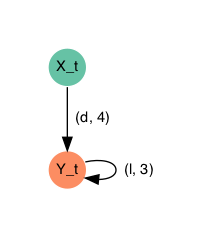

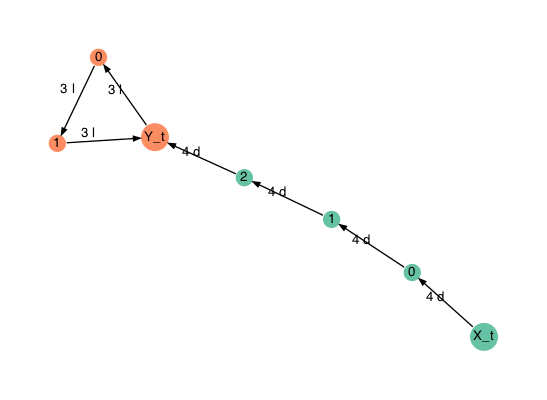

In [4]:
# test is based on the following specific network
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

net = me.Network('net_test_1')
net.structure(t)

me.plots.net_main_plot(net)
me.plots.net_hidden_plot(net)

##### Gillespie simulations (independent / framework external)

In [58]:
def gill_indep_test_1(initial_state, time_values, d, l, num_iter):
    # initialisation
    res = np.zeros((num_iter, 7, time_values.shape[0]))
    
    for i in range(num_iter):
        time_current = time_values[0]
        time_max = time_values[-1]
        cell_state = np.zeros(7)
        cell_state = copy.deepcopy(initial_state)
        
#         print('iter: ', i)
#         print('time_current: ', time_current)
#         print('time_max: ', time_max)
#         print('cell_state: ', cell_state)
        
        while time_current <= time_max:
            # reaction propensities
            reac_props = np.array([
                4.0 * d * cell_state[0], # d from Xcentric to X0
                4.0 * d * cell_state[1], # d from X0 to X1
                4.0 * d * cell_state[2], # d from X1 to X2
                4.0 * d * cell_state[3], # d from X2 to Ycentric
                3.0 * l * cell_state[4], # l from Ycentric to Y0
                3.0 * l * cell_state[5], # l from Y0 to Y1
                3.0 * l * cell_state[6], # l from Y1 to Ycentric
            ])
#             print('\n while start')
#             print('reac_props: ', reac_props)

            # draw exponential random time for next reaction
            total_prop = np.sum(reac_props)
            dt = np.random.exponential(1.0/total_prop)
            
#             print('total_prop: ', total_prop)
#             print('dt: ', dt)

            # save cell state results for relevant time points
            for ind in np.where((time_values >= time_current) 
                                & (time_values < time_current + dt))[0]:
                res[i, :, ind] = copy.deepcopy(cell_state).reshape((1,7))
            
#             print('res: ', res)
            
            # draw which reaction takes place
            reac_probs = reac_props/np.sum(reac_props)
            reac_rand = np.random.choice(reac_props.shape[0], p=reac_probs)
            
#             print('reac_probs: ', reac_probs)
#             print('reac_rand: ', reac_rand)

            # update cell state according to selected reaction
            # differentiation
            if reac_rand==0:
                cell_state[0] += -1.0
                cell_state[1] += +1.0
            elif reac_rand==1:
                cell_state[1] += -1.0
                cell_state[2] += +1.0
            elif reac_rand==2:
                cell_state[2] += -1.0
                cell_state[3] += +1.0
            elif reac_rand==3:
                cell_state[3] += -1.0
                cell_state[4] += +1.0

            # division
            elif reac_rand==4:
                cell_state[4] += -1.0
                cell_state[5] += +1.0
            elif reac_rand==5:
                cell_state[5] += -1.0
                cell_state[6] += +1.0
            elif reac_rand==6:
                cell_state[6] += -1.0
                cell_state[4] += +2.0
            else:
                print('error')

            # update current time by delta t
            time_current += dt
            
#             print('cell_state: ', cell_state)
#             print('time_current: ', time_current)
#             print('\n')
    
    # sum hidden states to get observable layer
    res_obs = np.zeros((num_iter, 2, time_values.shape[0]))
    res_obs[:, 0, :] = np.sum(res[:, (0,1,2,3), :], axis=1)
    res_obs[:, 1, :] = np.sum(res[:, (4,5,6), :], axis=1)
    return res_obs

In [61]:
# order of the variables of the hidden layer
# X centric, X diff 0, X diff 1, X diff 2, Y centric, Y div 0, Y div 1
initial_values = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
d = 0.04
l = 0.06
num_iter = 50000
print(time_values)

# save result as external simulation results
sim_res_ext = gill_indep_test_1(initial_values, time_values, d, l, num_iter)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]
(5, 2, 28)


In [62]:
print(sim_res_ext.shape)

(50000, 2, 28)


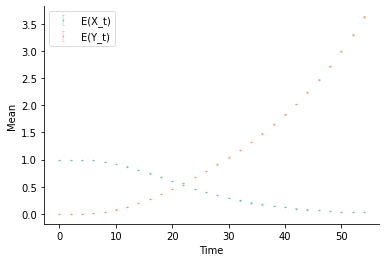

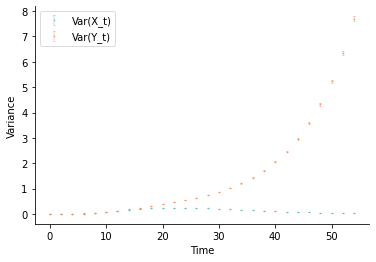

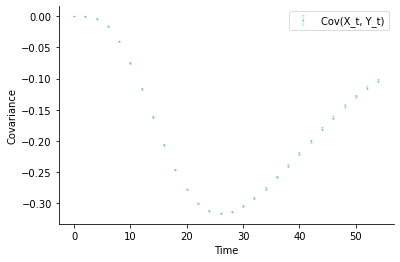

In [63]:
data_ext = me.Data('data_test_1_external')
data_ext.load(['X_t', 'Y_t'], time_values, sim_res_ext, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_ext)
me.plots.data_variance_plot(data_ext)
me.plots.data_covariance_plot(data_ext)

##### Gillespie simulations (framework)

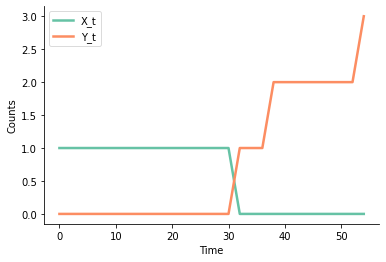

In [5]:
# compute Gillespie simulation with the framework
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_1')
net.structure(t)

sim = me.Simulation(net)
res = sim.simulate('gillespie', initial_values, theta_values, time_values, variables)

me.plots.sim_counts_plot(sim)

In [6]:
# create a data object from simulations for the estimation
num_iter = 10000

res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

sim_res_int = np.array(res_list)

In [7]:
sim_res_int.shape

(10000, 2, 28)

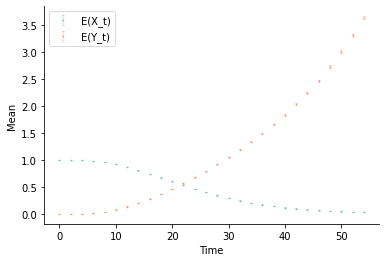

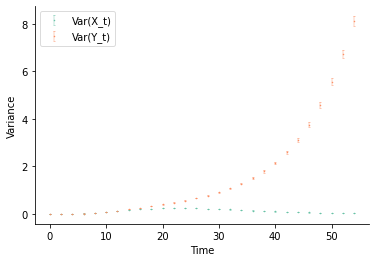

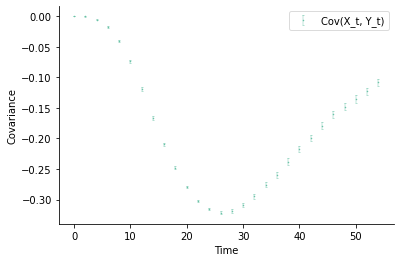

In [6]:
data_int = me.Data('data_test_1_internal')
data_int.load(['X_t', 'Y_t'], time_values, sim_res_int, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_int)
me.plots.data_variance_plot(data_int)
me.plots.data_covariance_plot(data_int)

##### Moment simulations (framework)

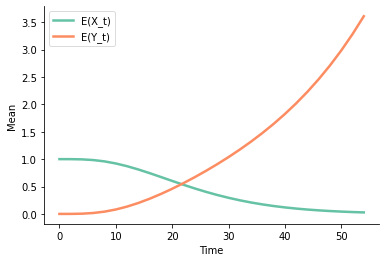

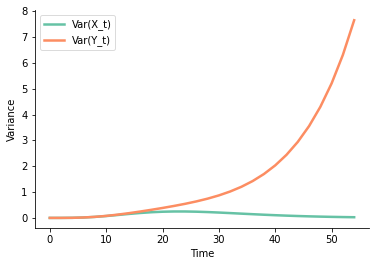

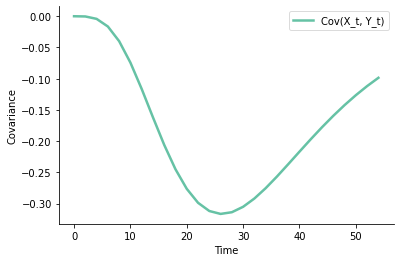

In [10]:
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_1')
net.structure(t)

sim = me.Simulation(net)
res = sim.simulate('moments', initial_values, theta_values, time_values, variables)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

##### Models for estimation

In [64]:
def make_model(steps_d, steps_l):
    name = 'net_' + str(steps_d) + '_' + str(steps_l)

    t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': steps_d},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': steps_l}
    ]

    s = {'initial_values': {'X_t': 1.0, 'Y_t': 0.0}, 
         'theta_bounds': {'d': (0.0, 0.15), 'l': (0.0, 0.15)}, 
         'variables': {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}}

    return (name, t, s)

models = [make_model(steps_d, steps_l) for steps_d in range(1, 6) for steps_l in range(1, 6)]
print(len(models))

25


##### Estimation of internal simulated data

In [7]:
d = {
# model set
'model_set': models,

# data/model settings
'data': data_int,
'mean_only': False, # True or False

# nested sampling settings
'nlive':                    1000, # 250 # 1000
'tolerance':                0.01, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
'bound':                    'multi',
'sample':                   'unif'
}

est_res_int = me.select_models(d, parallel={'do':False})

25


17


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

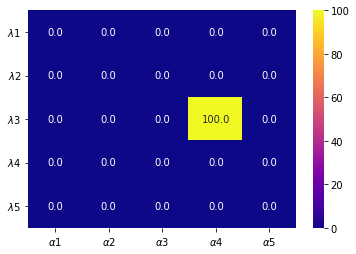

In [10]:
net_names = [est.net.net_name for est in est_res_int]
model_probs = me.selection.compute_model_probabilities(est_res_int)
print(net_names.index('net_4_3'))

steps_lambda = range(1, 6)
steps_alpha = range(1, 6)
rows = [fr'$\lambda{i}$' for i in steps_lambda]
cols = [fr'$\alpha{i}$' for i in steps_alpha]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(6, 4)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')

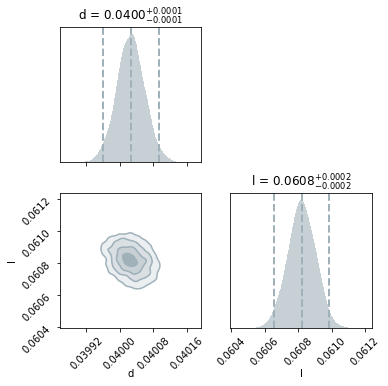

In [11]:
est = est_res_int[17]
me.plots.est_corner_kernel_plot(est)

##### Estimation of external simulated data

In [65]:
d = {
# model set
'model_set': models,

# data/model settings
'data': data_ext,
'mean_only': False, # True or False

# nested sampling settings
'nlive':                    1000, # 250 # 1000
'tolerance':                0.01, # 0.1 (COARSE) # 0.05 # 0.01 (NORMAL)
'bound':                    'multi',
'sample':                   'unif'
}

est_res_ext = me.select_models(d, parallel={'do':False})

In [69]:
est = est_res_ext[17]
est

In [76]:
est = est_res_ext[17]
model_evids = [est.bay_est_log_evidence for est in est_res_ext]
model_evids

[-1830057.7437922955,
 -1778137.0378948185,
 -1767837.4375730937,
 -1765219.903293404,
 -1764569.3128811514,
 -271990.7969605249,
 -230405.3298469227,
 -218961.60386432378,
 -214452.73980326057,
 -212293.96488182957,
 -57035.15112216298,
 -30140.369319240453,
 -24326.014232274407,
 -22724.030772199334,
 -22334.588270224023,
 -18037.180793000916,
 -1100.9556047649337,
 722.3420127590076,
 201.54544319244997,
 -724.2237032662088,
 -19838.30825931804,
 -9761.199701400114,
 -10719.230993168485,
 -12738.13550346512,
 -14599.13500538417]

In [87]:
# read out evidence list
logevids = np.array([est.bay_est_log_evidence for est in est_res_ext])

# due to overflow cut off very high evidences (wont change result much)
logevids[logevids > 700.0] = 700
print(logevids)

# log model prior (log of model number)
# assuming uniform model prior
logmprior = - np.log(logevids.shape[0])

# calculate normalising factor p(D)
logpdata = np.log(np.sum(np.exp(logevids))) + logmprior

# calculate model probabilities
model_probs = np.exp(logevids + logmprior - logpdata)
model_probs

[-1.83005774e+06 -1.77813704e+06 -1.76783744e+06 -1.76521990e+06
 -1.76456931e+06 -2.71990797e+05 -2.30405330e+05 -2.18961604e+05
 -2.14452740e+05 -2.12293965e+05 -5.70351511e+04 -3.01403693e+04
 -2.43260142e+04 -2.27240308e+04 -2.23345883e+04 -1.80371808e+04
 -1.10095560e+03  7.00000000e+02  2.01545443e+02 -7.24223703e+02
 -1.98383083e+04 -9.76119970e+03 -1.07192310e+04 -1.27381355e+04
 -1.45991350e+04]


array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.00000000e+000, 3.34146179e-217, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

17


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

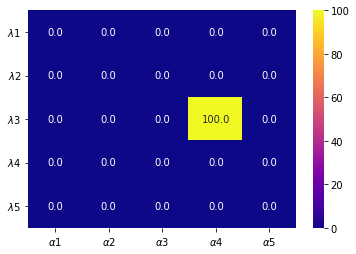

In [88]:
net_names = [est.net.net_name for est in est_res_ext]
# model_probs = me.selection.compute_model_probabilities(est_res_ext)
print(net_names.index('net_4_3'))

steps_lambda = range(1, 6)
steps_alpha = range(1, 6)
rows = [fr'$\lambda{i}$' for i in steps_lambda]
cols = [fr'$\alpha{i}$' for i in steps_alpha]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(6, 4)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')

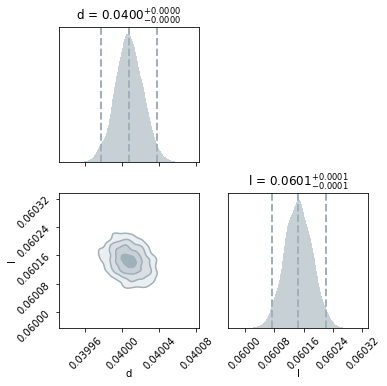

In [89]:
est = est_res_ext[17]
me.plots.est_corner_kernel_plot(est)

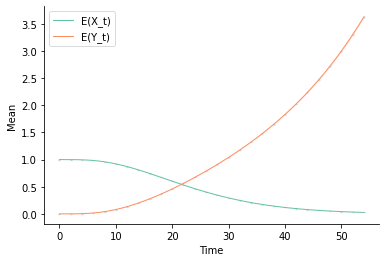

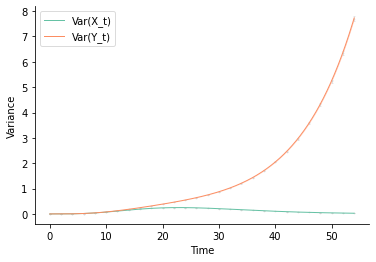

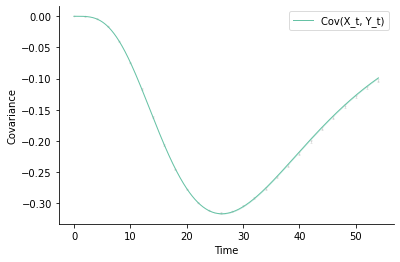

In [91]:
est = est_res_ext[17]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)